### IMPORT LIBRARIES

In [2]:
import cv2
import os
import datetime as dt
import glob
import itertools
import matplotlib.pylab as plt
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from keras import models, layers, optimizers
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings("ignore")
%matplotlib inline

### PATH TO TRAIN AND VALIDATION DATA

Here we will define the paths to our dataset. So we have stored training and testing data in their respective folders. We will provide the respective paths to our training and testing data

In [3]:
train_dir = "F:/datasets/Monkey/training/" #path to the folder where training data is stored
test_dir = "F:/datasets/Monkey/validation/" #path to the folder where validation data is stored

### GENERATORS

Here we will define a function which will help us to load the data directly from our folders. We will use keras's ImageDataGeenrator class to do so. There will be two functions for loading training and testing data.

In [4]:
# Training generator

def train_image_data_generator(train_dir, height, width, batch_size, seed):
    """
    train_dir = path to our training data
    height = Height of the image
    width = Width of the image
    batch_size = Number of images to be loaded in a single batch
    see = For reproducibility
    """
    train_datagen = ImageDataGenerator(rescale = 1./255)
    train_generator = train_datagen.flow_from_directory(train_dir, 
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed,
                                                        class_mode = 'categorical')
    return train_generator

# Test generator
def test_image_data_generator(test_dir, height, width, batch_size, seed):
    """
    test_dir = path to our testing data
    height = Height of the image
    width = Width of the image
    batch_size = Number of images to be loaded in a single batch
    see = For reproducibility
    """
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_generator = test_datagen.flow_from_directory(test_dir, 
                                                      target_size = (height,width), 
                                                      batch_size = batch_size,
                                                      seed = seed,
                                                      class_mode = 'categorical')
    return test_generator

## FEATURE EXTRACTION

Here we will define a generalized function which will help us to extract features from the given input data. For extracting the data, we will be using some pre-trained imagenet models with their classification layer cut-off

In [5]:
def extract_features(sample_count, datagen, model, feature_width, feature_height, feature_channels):
    """
    sample_count = Total number of examples in the training or testing data
    datagen = Training or Testing data generator
    model = Pre-trained Model to be used to extract features
    feature_width = The width of the feature map in the last activation layer
    feature_height = The height of the feature map in the last acctivation layer
    feature_channels = The number of feature maps in the last layer
    """
    features =  np.zeros(shape = (sample_count, feature_width, feature_height, feature_channels))
    labels = np.zeros(shape = (sample_count, 10))
    generator = datagen
    i = 0
    for inputs_batch, labels_batch in generator:
        
        features_batch = model.predict(inputs_batch)
        
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        
        if i * batch_size >= sample_count:
            break
            
    print("\n")
    
    return features, labels

## DEFINE CALLBACKS

Here we will define a single callback function called ReduceLROnPlateau. With the help of this callback, we can alter our learning rate if the loss appears to plateau.

In [6]:
#defining callbacks
def model_callbacks(monitor, factor, patience, cooldown, min_lr):
    """
    monitor = Quantity to be monitored.
    factor = Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience = Number of epochs with no improvement after which learning rate will be reduced.
    cooldown = Number of epochs to wait before resuming normal operation after lr has been reduced.
    min_lr = Lower bound on the learning rate.
    """
    reduce_learning_rate = ReduceLROnPlateau(monitor = monitor,
                                             factor = factor,
                                             patience = patience,
                                             cooldown = cooldown,
                                             min_lr = min_lr,
                                             verbose = 1)

    callbacks = [reduce_learning_rate]
    return callbacks

### PLOT LOSS AND ACCURACY CURVES

Here we will write a function which would plot us an accuracy and loss plots after the model has been trained

In [7]:
def plot_curve(history, model_name):
    """
    history = The variable while fitting the model on the dataset
    model_name = The name of the model (string)
    """
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize = (15,12))
    plt.subplot(211)
    plt.plot(epochs, acc, 'bo', label = 'Training acc')
    plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
    plt.title(model_name + " --" + ' Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.figure(figsize = (15,12))
    plt.subplot(212)
    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.title(model_name + " --" + ' Training and validation loss')
    plt.legend()
    plt.show()

### FC MODEL FOR CLASSIFICATION

Here we will define a function for fully connected neural network. We will use this neural network to make classifications on the extracted features from our input data

In [8]:
def dense_model():
    model = models.Sequential()
    model.add(layers.Dense(512, activation = 'relu', input_dim = flat_dim))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation = 'relu', input_dim = flat_dim))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation = 'softmax'))
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
    model.summary()
    return model

## MODEL 1 - XCEPTION

In [12]:
# Initialize the base model
#define the parameters required to be passed to ur function
height = 150
width = 150
channels = 3
batch_size = 32
seed = 1337

xception_model = Xception(weights = "imagenet",
                          include_top = False,
                          input_shape = (height, width, channels))

In [13]:
#call the geenrator functions to load our data from the folders

train_generator = train_image_data_generator(train_dir = train_dir,
                                            height = height,
                                            width = height,
                                            batch_size = batch_size,
                                            seed = seed)

test_generator = test_image_data_generator(test_dir = test_dir,
                                          height = height,
                                          width = width,
                                          batch_size = batch_size,
                                          seed = seed)

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [14]:
#call the extract_features functions
feature_width = 5 #this the output width of the last xception layer
feature_height = 5 #this the output height of the last xception layer
feature_channels = 2048 #this the output channels of the last xception layer

train_features, train_labels = extract_features(train_generator.samples, 
                                                train_generator, 
                                                xception_model,
                                                feature_width = feature_width,
                                                feature_height = feature_height,
                                                feature_channels = feature_channels)

test_features, test_labels = extract_features(test_generator.samples, 
                                              test_generator, 
                                              xception_model,
                                              feature_width = feature_width,
                                              feature_height = feature_height,
                                              feature_channels = feature_channels)

In [15]:
#flatten the dimension of the input
flat_dim = 5 * 5 * 2048

#reshape the training and test features to have a shape of ----> [batch_size, input_dim]
train_features = np.reshape(train_features, (train_generator.samples, flat_dim))
test_features = np.reshape(test_features, (test_generator.samples, flat_dim))

In [16]:
#call the dense_model function to build our classification model
model = dense_model()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 26,348,810
Trainable params: 26,348,810
Non-trainable params: 0
_________________________________________________________________


In [17]:
#call the callbacks function
callbacks = model_callbacks("loss", 0.1, 2, 2, 0.00001)

In [57]:
xception_history = model.fit(train_features, 
                    train_labels, 
                    epochs = 30,
                    batch_size = batch_size,
                    shuffle = True,
                    validation_data = (test_features, test_labels),
                    verbose = 2,
                    callbacks = callbacks)

Train on 1097 samples, validate on 272 samples
Epoch 1/30
 - 14s - loss: 6.7559 - acc: 0.4932 - val_loss: 4.9567 - val_acc: 0.6654
Epoch 2/30
 - 11s - loss: 4.6700 - acc: 0.6782 - val_loss: 3.8584 - val_acc: 0.7390
Epoch 3/30
 - 11s - loss: 4.2657 - acc: 0.7147 - val_loss: 3.4684 - val_acc: 0.7721
Epoch 4/30
 - 11s - loss: 4.0157 - acc: 0.7347 - val_loss: 3.8190 - val_acc: 0.7537
Epoch 5/30
 - 11s - loss: 4.0637 - acc: 0.7302 - val_loss: 4.3158 - val_acc: 0.7206
Epoch 6/30
 - 11s - loss: 3.8469 - acc: 0.7511 - val_loss: 3.0010 - val_acc: 0.8051
Epoch 7/30
 - 11s - loss: 3.8812 - acc: 0.7475 - val_loss: 2.7118 - val_acc: 0.8199
Epoch 8/30
 - 12s - loss: 3.4716 - acc: 0.7703 - val_loss: 3.4467 - val_acc: 0.7757
Epoch 9/30
 - 12s - loss: 3.4304 - acc: 0.7785 - val_loss: 3.1368 - val_acc: 0.7978
Epoch 10/30
 - 12s - loss: 3.4399 - acc: 0.7767 - val_loss: 3.7331 - val_acc: 0.7647
Epoch 11/30
 - 11s - loss: 3.9916 - acc: 0.7438 - val_loss: 3.0821 - val_acc: 0.7941

Epoch 00011: ReduceLROnPla

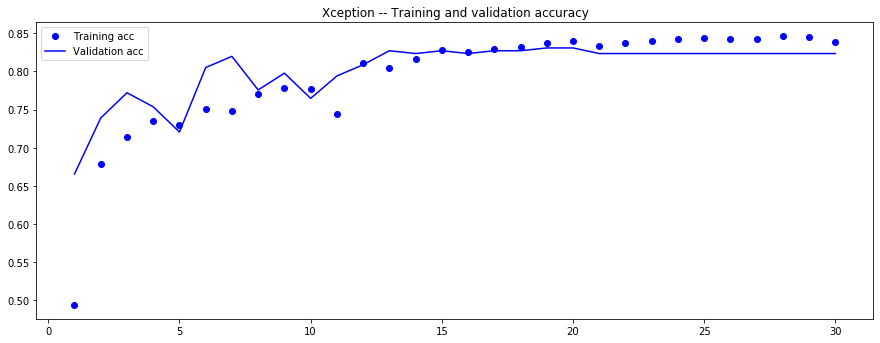

<Figure size 432x288 with 0 Axes>

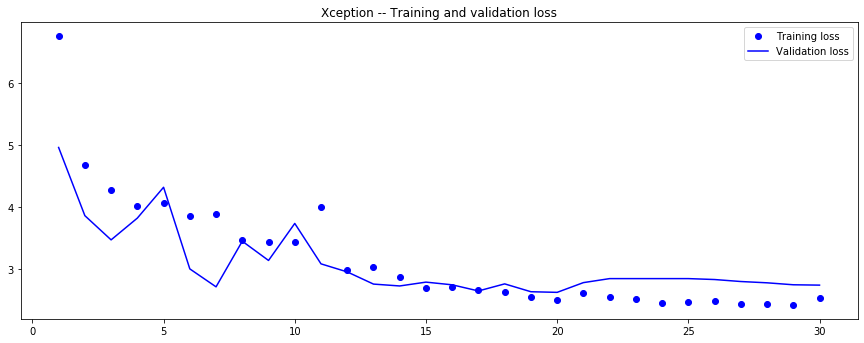

In [65]:
#call the plot_curves function to plot the loss and accuracy plots
plot_curve(xception_history, "Xception")

## MODEL 2 - INCEPTION

In [18]:
#instantiate the "INCEPTION" model
#Here we will use a pretrained inception model trained on IMAGENET dataset
#define the parameters required to be passed to ur function
height = 150
width = 150
channels = 3
batch_size = 32
seed = 1337

inception_model = InceptionV3(weights = "imagenet", include_top = False, input_shape = (height, width, channels))

In [19]:
#call the generator functions to load our data from the folders

train_generator = train_image_data_generator(train_dir = train_dir,
                                            height = height,
                                            width = height,
                                            batch_size = batch_size,
                                            seed = seed)

test_generator = test_image_data_generator(test_dir = test_dir,
                                          height = height,
                                          width = width,
                                          batch_size = batch_size,
                                          seed = seed)

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [20]:
#call the extract features function
feature_width = 3 #this the output width of the last inception layer
feature_height = 3 #this is the output height of the last inception layer
feature_channels = 2048 #this the number of channels in the last inception layer

train_features, train_labels = extract_features(train_generator.samples, 
                                                train_generator, 
                                                inception_model,
                                                feature_width = feature_width,
                                                feature_height = feature_height,
                                                feature_channels = feature_channels)

test_features, test_labels = extract_features(test_generator.samples, 
                                              test_generator, 
                                              inception_model,
                                              feature_width = feature_width,
                                              feature_height = feature_height,
                                              feature_channels = feature_channels)

In [21]:
flat_dim = 3 * 3 * 2048
train_features = np.reshape(train_features, (train_generator.samples, flat_dim))
test_features = np.reshape(test_features, (test_generator.samples, flat_dim))

In [22]:
#call the dense_model function to build our classification model
model = dense_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total params: 9,571,594
Trainable params: 9,571,594
Non-trainable params: 0
_________________________________________________________________


In [23]:
#call the model_callbacks function
callbacks = model_callbacks("loss", 0.1, 2, 2, 0.00001)

In [35]:
inception_history = model.fit(train_features, 
                              train_labels, 
                              epochs = 30,
                              batch_size = batch_size,
                              validation_data = (test_features, test_labels),
                              verbose = 2,
                              callbacks = callbacks)

Train on 1097 samples, validate on 272 samples
Epoch 1/30
 - 7s - loss: 10.0900 - acc: 0.3136 - val_loss: 8.1237 - val_acc: 0.4669
Epoch 2/30
 - 4s - loss: 7.7734 - acc: 0.4913 - val_loss: 6.3298 - val_acc: 0.5956
Epoch 3/30
 - 4s - loss: 6.3069 - acc: 0.5880 - val_loss: 6.5623 - val_acc: 0.5772
Epoch 4/30
 - 4s - loss: 5.9777 - acc: 0.6080 - val_loss: 3.7089 - val_acc: 0.7610
Epoch 5/30
 - 4s - loss: 4.6310 - acc: 0.6901 - val_loss: 4.1191 - val_acc: 0.7426
Epoch 6/30
 - 4s - loss: 4.2667 - acc: 0.7165 - val_loss: 3.2528 - val_acc: 0.7941
Epoch 7/30
 - 4s - loss: 4.0726 - acc: 0.7238 - val_loss: 4.6435 - val_acc: 0.6765
Epoch 8/30
 - 4s - loss: 4.2434 - acc: 0.7192 - val_loss: 2.4101 - val_acc: 0.8346
Epoch 9/30
 - 4s - loss: 2.5147 - acc: 0.8259 - val_loss: 1.8866 - val_acc: 0.8640
Epoch 10/30
 - 4s - loss: 2.5251 - acc: 0.8232 - val_loss: 1.9716 - val_acc: 0.8566
Epoch 11/30
 - 4s - loss: 2.0371 - acc: 0.8624 - val_loss: 2.3788 - val_acc: 0.8382
Epoch 12/30
 - 4s - loss: 2.1528 - ac

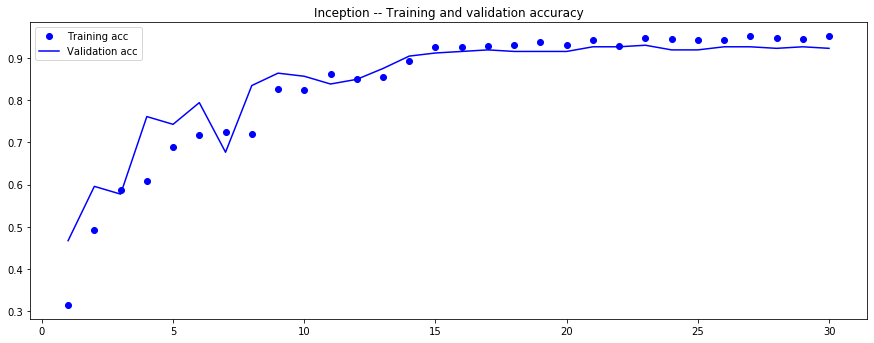

<Figure size 432x288 with 0 Axes>

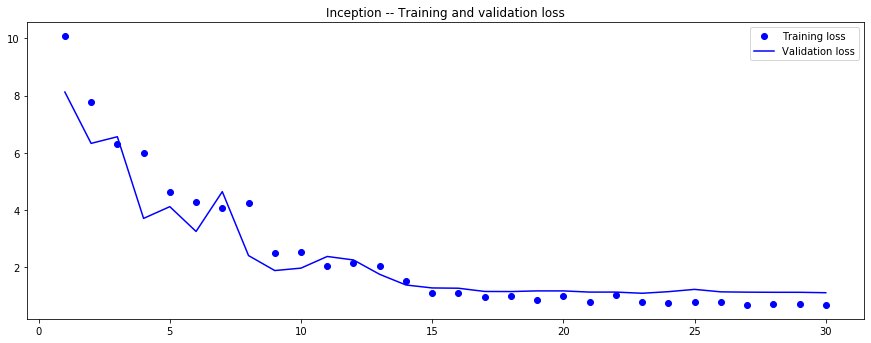

In [66]:
#call the plot_curves function to plot the loss and accuracy plots for inception model
plot_curve(inception_history, "Inception")

## MODEL 3 - InceptionResnetV2

In [10]:
#instantiate the "INCEPTIONRESNETV2" model
#Here we will use a pretrained "INCEPTIONRESNETV2" model trained on IMAGENET dataset
#define the parameters required to be passed to our function
height = 150
width = 150
channels = 3
batch_size = 32
seed = 1337

resnet_model = InceptionResNetV2(weights = "imagenet", include_top = False, input_shape = (height, width, channels))

In [11]:
#call the generator functions to load our data from the folders

train_generator = train_image_data_generator(train_dir = train_dir,
                                             height = height,
                                             width = height,
                                             batch_size = batch_size,
                                             seed = seed)

test_generator = test_image_data_generator(test_dir = test_dir,
                                           height = height,
                                           width = width,
                                           batch_size = batch_size,
                                           seed = seed)

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [12]:
#call the extract features function
feature_width = 3 #this the output width of the last inception layer
feature_height = 3 #this is the output height of the last inception layer
feature_channels = 1536 #this the number of channels in the last inception layer

train_features, train_labels = extract_features(train_generator.samples, 
                                                train_generator, 
                                                resnet_model,
                                                feature_width = feature_width,
                                                feature_height = feature_height,
                                                feature_channels = feature_channels)

test_features, test_labels = extract_features(test_generator.samples, 
                                              test_generator, 
                                              resnet_model,
                                              feature_width = feature_width,
                                              feature_height = feature_height,
                                              feature_channels = feature_channels)

In [13]:
flat_dim = 3 * 3 * 1536
train_features = np.reshape(train_features, (train_generator.samples, flat_dim))
test_features = np.reshape(test_features, (test_generator.samples, flat_dim))

In [14]:
#call the dense_model function to build our classification model
model = dense_model()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               7078400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 7,212,298
Trainable params: 7,212,298
Non-trainable params: 0
_________________________________________________________________


In [15]:
#call the model_callbacks function
callbacks = model_callbacks("loss", 0.1, 2, 2, 0.00001)

In [16]:
resnet_history = model.fit(train_features, 
                           train_labels, 
                           epochs = 30,
                           batch_size = batch_size,
                           validation_data = (test_features, test_labels),
                           verbose = 2,
                           callbacks = callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 1097 samples, validate on 272 samples
Epoch 1/30
 - 8s - loss: 9.2529 - acc: 0.3728 - val_loss: 7.4812 - val_acc: 0.5184
Epoch 2/30
 - 3s - loss: 8.3104 - acc: 0.4704 - val_loss: 7.8823 - val_acc: 0.5074
Epoch 3/30
 - 3s - loss: 7.3961 - acc: 0.5351 - val_loss: 8.3995 - val_acc: 0.4743
Epoch 4/30
 - 3s - loss: 7.5752 - acc: 0.5214 - val_loss: 7.2339 - val_acc: 0.5478
Epoch 5/30
 - 3s - loss: 7.3596 - acc: 0.5387 - val_loss: 7.4354 - val_acc: 0.5294
Epoch 6/30
 - 3s - loss: 7.2680 - acc: 0.5406 - val_loss: 6.7012 - val_acc: 0.5809
Epoch 7/30
 - 3s - loss: 6.9400 - acc: 0.5588 - val_loss: 5.9699 - val_acc: 0.6213
Epoch 8/30
 - 3s - loss: 5.9147 - acc: 0.6253 - val_loss: 5.7569 - val_acc: 0.6360
Epoch 9/30
 - 3s - loss: 6.0769 - acc: 0.6199 - val_loss: 5.8735 - val_acc: 0.6324
Epoch 10/30
 - 3s - loss: 5.7880 - acc: 0.6372 - val_loss: 5.4195 - val_acc: 0.6618
Epoch 11/30
 - 3s - loss: 5.5957 - acc: 0.6509 - val_loss: 5.6378 - val_ac

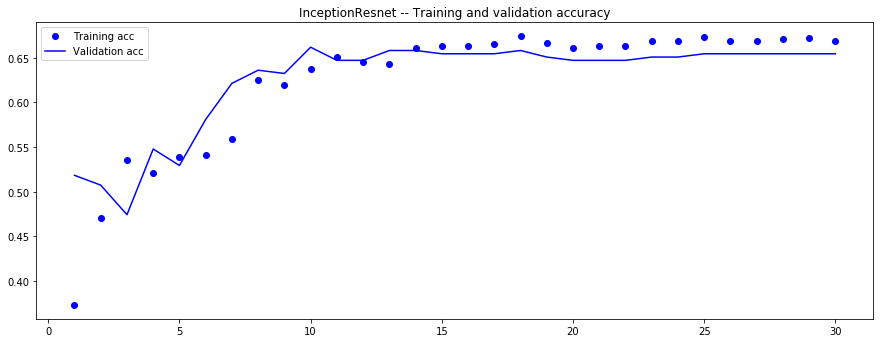

<Figure size 432x288 with 0 Axes>

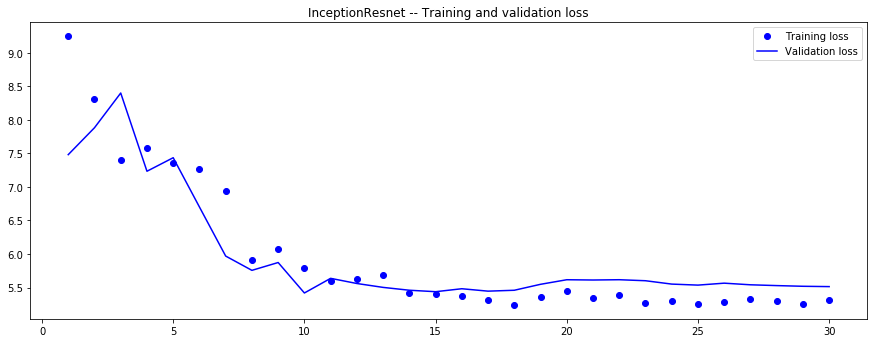

In [17]:
#call the plot_curves function to plot the loss and accuracy plots for inception model
plot_curve(resnet_history, "InceptionResnet")